In [5]:
import numpy as np
import pandas as pd
import networkx as nx

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
import networkx.algorithms.smallworld as sw
import networkx.algorithms.community as nx_comm
import mne
from scipy.signal import coherence, hilbert

In [4]:
!pip install seaborn

     -------------------------------------- 294.9/294.9 kB 1.8 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# hubs mas grandes y diferente color de cada comunidad, hubs con aristas de diferente color
edf_path=r"C:\Users\V304-16\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf"
sfreq_target=256 #frecuencias demuestreo a la que estamos normalizando
fmin,fmax=8,13 #banda alfa para la coherencia
raw= mne.io.read_raw_edf(edf_path, preload=True)
raw.resample(sfreq_target)
raw.filter(1.,45.,fir_design='firwin')
data= raw.get_data()
ch_names = raw.info['ch_names']
n_channels = len(ch_names)

Extracting EDF parameters from C:\Users\V304-16\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 921599  =      0.000 ...  3599.996 secs...


C:\Users\V304-16\AppData\Local\Temp\ipykernel_17004\501536158.py:5: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw= mne.io.read_raw_edf(edf_path, preload=True)


Sampling frequency of the instance is already 256.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (3.301 s)



In [7]:
# ====== 2. MATRIZ DE COHERENCIA ESPECTRAL ======use esta matriz porque según lo que investigué es la mas adecuada para analizar datos de EEG
coh_matrix = np.zeros((n_channels, n_channels))
for i in range(n_channels):
    for j in range(n_channels):
        f, Cxy = coherence(data[i], data[j], fs=sfreq_target, nperseg=sfreq_target*2)
        mask = (f >= fmin) & (f <= fmax)
        coh_matrix[i, j] = np.mean(Cxy[mask])

coh_df = pd.DataFrame(coh_matrix, index=ch_names, columns=ch_names)
np.fill_diagonal(coh_df.values, 0)

In [11]:
def metricas_grafo(G):
    # Métricas:
    # (a) Clustering promedio (coeficiente de agrupamiento)
    clust_coeff = nx.average_clustering(G)
    # (b) Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan  # red no conexa
    # (c) Small-worldness (ejemplo simplificado)
    # Comparar con grafo aleatorio de igual N, K
    G_rand = nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand = nx.average_clustering(G_rand)
    path_rand = nx.average_shortest_path_length(G_rand)
    small_world_sigma = (clust_coeff / clust_rand) / (path_length / path_rand)
    
    # (d) Modularidad — usando método de comunidades
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)
    
    # (e) Hubs — grado, centralidad de intermediación
    degree_dict = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    
    # (f) Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict

In [12]:
data = coh_df.stack().values
threshold = np.percentile(data, 25)

data = coh_df[coh_df>threshold].stack().values
df_filtered = coh_df.where(coh_df > threshold, 0)

# Generar grafo desde matriz
eeg_graph = nx.from_pandas_adjacency(df_filtered, create_using=nx.Graph())

clust_coeff, path_length, small_world_sigma, communities, modularity, betweenness, global_eff, local_eff, degree_dict = metricas_grafo(eeg_graph)

hub = betweenness[0]

In [13]:
coord3d=r"C:\Users\V304-16\Documents\GitHub\Neurociencias-2026-1\S03_datasets\EEG_practica\coordenadas_bipolares_eeg.csv"
coord=pd.read_csv(coord3d)
coord.set_index('canal', inplace=True, drop=True)
coh_df.columns = [columna.split(sep = ' ')[0] for columna in coh_df.columns]
coh_df.index = coh_df.columns

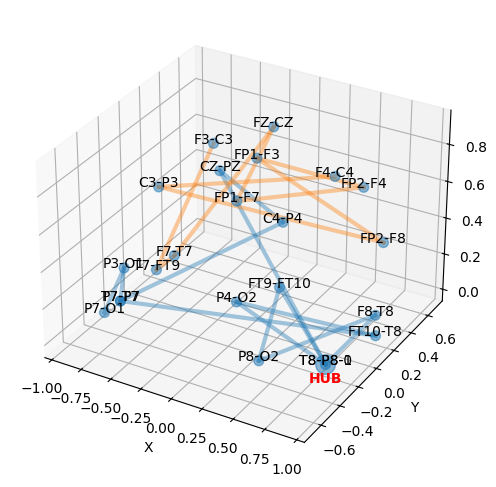

In [15]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection

# %matplotlib widget
# Creamos el plot3D del grafo
x, y, z = coord.loc[:, 'x'].values, coord.loc[:, 'y'].values, coord.loc[:, 'z'].values
colors = [
    'tab:blue',      # azul
    'tab:orange',    # naranja
    'tab:green',     # verde
    'tab:red',       # rojo
    'tab:purple',    # morado
    'tab:brown',     # café
    'tab:pink',      # rosa
    'tab:gray',      # gris
    'tab:olive',     # verde oliva
    'tab:cyan',      # cian
    'gold',          # dorado
    'deepskyblue',   # azul brillante
    'limegreen',     # verde limón
    'magenta',       # magenta
    'black'          # negro
]
nodo_size = [50 if idx != hub[0] else 200 for idx in coord.index]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# DIBUJAR LOS NODOS
sc = ax.scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
    ax.text(x_, y_, z_, coord.index[idx], fontsize=10, ha='center')
    if coord.index[idx] == hub[0]:
        ax.text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')

# Dibujar aristas (basado en comunidades)
for n_communitie, communitie in enumerate(communities):
    for idx in range(len(communitie)-1):
        nodo1, nodo2 = list(communitie)[idx], list(communitie)[idx+1]
        x_ = [coord.loc[nodo1, 'x'], coord.loc[nodo2, 'x']]
        y_ = [coord.loc[nodo1, 'y'], coord.loc[nodo2, 'y']]
        z_ = [coord.loc[nodo1, 'z'], coord.loc[nodo2, 'z']]
        ax.plot(x_, y_, z_, color=colors[n_communitie], alpha=0.4, linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

1. Dado el ejercicio anterior, crear maoa de calor utilizando el valor de threshold para mostrar la matriz binarizada
2. Hacer que ambos gráficos, el grafo 3D y el mapa de calor se vean juntos

<Axes: >

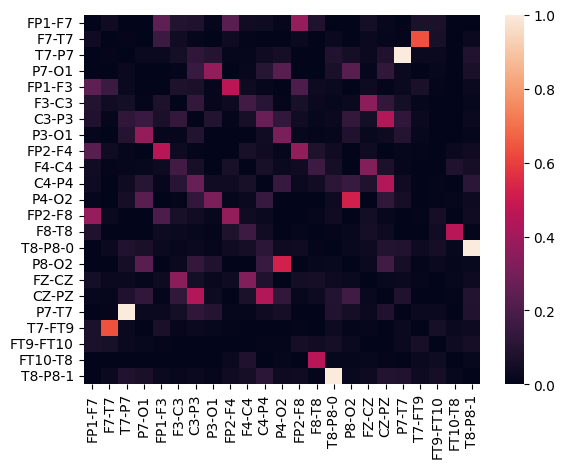

In [17]:
sns.heatmap(df_filtered)

<Axes: >

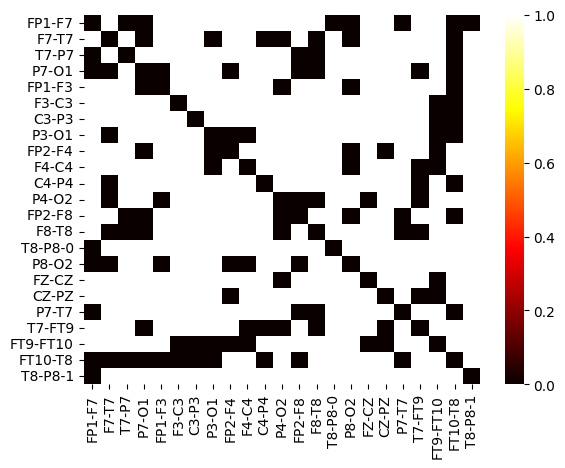

In [32]:
df_filt = np.where(coh_df > threshold, 1, 0)
df_filt=pd.DataFrame(df_filt,index=ch_names, columns=ch_names)
sns.heatmap(df_filt,cmap='hot')

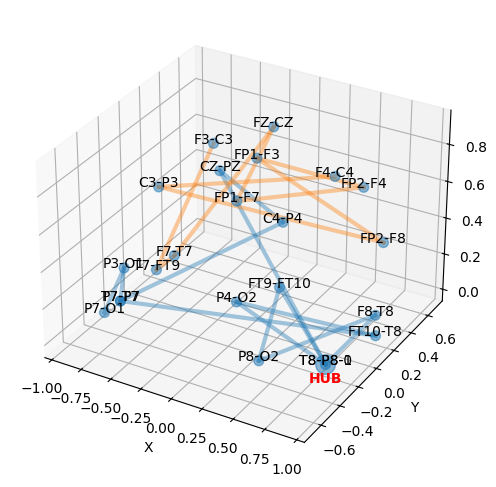

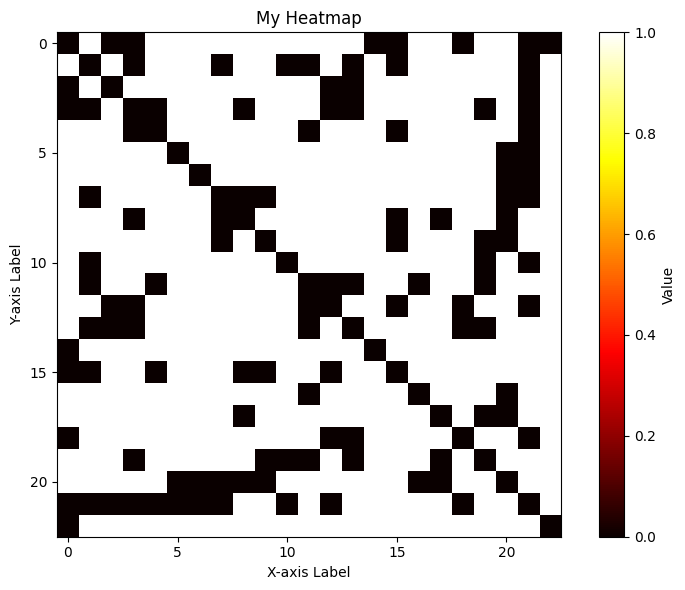

In [33]:
x, y, z = coord.loc[:, 'x'].values, coord.loc[:, 'y'].values, coord.loc[:, 'z'].values
colors = [
    'tab:blue',      # azul
    'tab:orange',    # naranja
    'tab:green',     # verde
    'tab:red',       # rojo
    'tab:purple',    # morado
    'tab:brown',     # café
    'tab:pink',      # rosa
    'tab:gray',      # gris
    'tab:olive',     # verde oliva
    'tab:cyan',      # cian
    'gold',          # dorado
    'deepskyblue',   # azul brillante
    'limegreen',     # verde limón
    'magenta',       # magenta
    'black'          # negro
]
nodo_size = [50 if idx != hub[0] else 200 for idx in coord.index]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# DIBUJAR LOS NODOS
sc = ax.scatter(x, y, z, s=nodo_size, alpha=0.5)#, c=degree_dict.values(), cmap='hot')
for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
    ax.text(x_, y_, z_, coord.index[idx], fontsize=10, ha='center')
    if coord.index[idx] == hub[0]:
        ax.text(x_, y_, z_-0.1, 'HUB', color='red', fontweight='bold', fontsize=10, ha='center')

# Dibujar aristas (basado en comunidades)
for n_communitie, communitie in enumerate(communities):
    for idx in range(len(communitie)-1):
        nodo1, nodo2 = list(communitie)[idx], list(communitie)[idx+1]
        x_ = [coord.loc[nodo1, 'x'], coord.loc[nodo2, 'x']]
        y_ = [coord.loc[nodo1, 'y'], coord.loc[nodo2, 'y']]
        z_ = [coord.loc[nodo1, 'z'], coord.loc[nodo2, 'z']]
        ax.plot(x_, y_, z_, color=colors[n_communitie], alpha=0.4, linewidth=3)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig, ax = plt.subplots(figsize=(8, 6)) # Create a figure and a single axes object

# 3. Use imshow() to display the data as a heatmap on the axes
im = ax.imshow(df_filt, cmap='hot') # 'viridis' is a common colormap

# 4. Add a color bar for interpretation
plt.colorbar(im, ax=ax, label='Value')

# 5. Set labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('My Heatmap')

# 6. Adjust layout
fig.tight_layout()

plt.show()

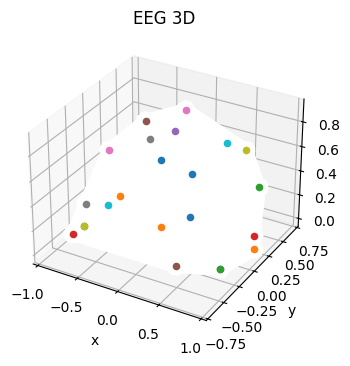

In [36]:
coord_df=pd.DataFrame(coord, columns=['x', 'y', 'z'])

pos3D={canal:(coord_df.loc[canal,'x'],
             coord_df.loc[canal,'y'],
             coord_df.loc[canal,'z']) for canal in coord_df.index}
GG = nx.from_pandas_adjacency(df_filt, create_using=nx.DiGraph());

fig= plt.figure(figsize=(4,4))
ax= fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('hot')
norm = plt.Normalize(df_filt.min().min(), df_filt.max().max())

for i, (x,y,z) in pos3D.items():
    ax.scatter(x,y,z)

for i,j, data in GG.edges(data=True):
    x=[pos3D[i][0],pos3D[j][0]]
    y=[pos3D[i][1],pos3D[j][1]]
    z=[pos3D[i][2],pos3D[j][2]]
    ax.plot(x,y,z,linewidth=data['weight']*10,color=cmap(norm(data['weight'])))


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('EEG 3D')
plt.show()